In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from causalimpact import CausalImpact
from datetime import timedelta

In [5]:
revenue = pd.read_csv('../data/revenue_loyal_customers.csv', index_col=0)
revenue['date'] = pd.to_datetime(revenue['date'])

In [6]:
revenue

,date,revenue
0,2021-06-28,5358695.20
1,2021-06-29,5377477.76
2,2021-06-30,5464551.08
3,2021-07-01,5891338.36
4,2021-07-02,6743656.05
...,...,...
275,2022-03-30,5679899.28
276,2022-03-31,5888872.90
277,2022-04-01,7470889.75
278,2022-04-02,6985402.32


In [7]:
# check if 'date' column is a datetime column
if revenue['date'].dtype == 'datetime64[ns]':
    print("The 'date' column is a datetime column")
else:
    print("The 'date' column is not a datetime column")

The 'date' column is a datetime column


### S&P index | Does not have data of closing value during weekend so have to add them

In [8]:
sp = pd.read_csv('../data/Download Data - INDEX_US_S&P US_SPX.csv')
sp = sp[['Date', 'Close']]
sp = sp.rename(columns={'Date': 'date', 'Close': 'close'})
sp['close'] = sp['close'].str.replace(',', '').astype(float)
sp.sort_values(by='date', inplace=True)
sp['date'] = pd.to_datetime(sp['date'], format='%m/%d/%Y')
sp['date'].dt.strftime('%Y-%m-%d')
sp.sort_values(by='date')
sp.set_index('date', inplace=True)

In [9]:
all_days = pd.date_range(min(revenue['date']), max(revenue['date']), freq='D')
all_days_df = pd.DataFrame(index=all_days)
all_days_df.index = pd.to_datetime(all_days_df.index)

In [10]:
sp_full = pd.merge(all_days_df, sp, how='outer', left_index=True, right_index=True)
sp_full.fillna(method='ffill', inplace=True)

In [11]:
sp_full

,close
2021-06-28,4290.61
2021-06-29,4291.80
2021-06-30,4297.50
2021-07-01,4319.94
2021-07-02,4352.34
...,...
2022-03-30,4602.45
2022-03-31,4530.41
2022-04-01,4545.86
2022-04-02,4545.86


### Merge new found tracker with the y predictor

In [12]:
ts_data = pd.merge(revenue, sp_full, how='outer', left_on='date', right_index=True)

In [13]:
ts_data

,date,revenue,close
0,2021-06-28,5358695.20,4290.61
1,2021-06-29,5377477.76,4291.80
2,2021-06-30,5464551.08,4297.50
3,2021-07-01,5891338.36,4319.94
4,2021-07-02,6743656.05,4352.34
...,...,...,...
275,2022-03-30,5679899.28,4602.45
276,2022-03-31,5888872.90,4530.41
277,2022-04-01,7470889.75,4545.86
278,2022-04-02,6985402.32,4545.86


### Define periods

In [14]:
ts_pre_period = [pd.to_datetime(date) for date in ['2021-06-28', '2021-11-14']]
ts_post_period = [pd.to_datetime(date) for date in ['2021-11-15', '2022-04-03']]
ts_pre_period = [date.strftime('%Y-%m-%d') for date in ts_pre_period]
ts_post_period = [date.strftime('%Y-%m-%d') for date in ts_post_period]

In [15]:
type(ts_data['date'].iloc[0])

pandas._libs.tslibs.timestamps.Timestamp

In [16]:
ts_data.set_index('date',inplace=True)

In [17]:
ts_data

,revenue,close
date,,
2021-06-28,5358695.20,4290.61
2021-06-29,5377477.76,4291.80
2021-06-30,5464551.08,4297.50
2021-07-01,5891338.36,4319.94
2021-07-02,6743656.05,4352.34
...,...,...
2022-03-30,5679899.28,4602.45
2022-03-31,5888872.90,4530.41
2022-04-01,7470889.75,4545.86


### Run CI

In [18]:
ts_impact = CausalImpact(ts_data, ts_pre_period, ts_post_period)
ts_impact.run()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.43123D+00    |proj g|=  2.10817D-01

At iterate    5    f=  1.33347D+00    |proj g|=  2.96279D-02

At iterate   10    f=  1.33242D+00    |proj g|=  2.89349D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     14      1     0     0   4.616D-06   1.332D+00
  F =   1.3324203716942999     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


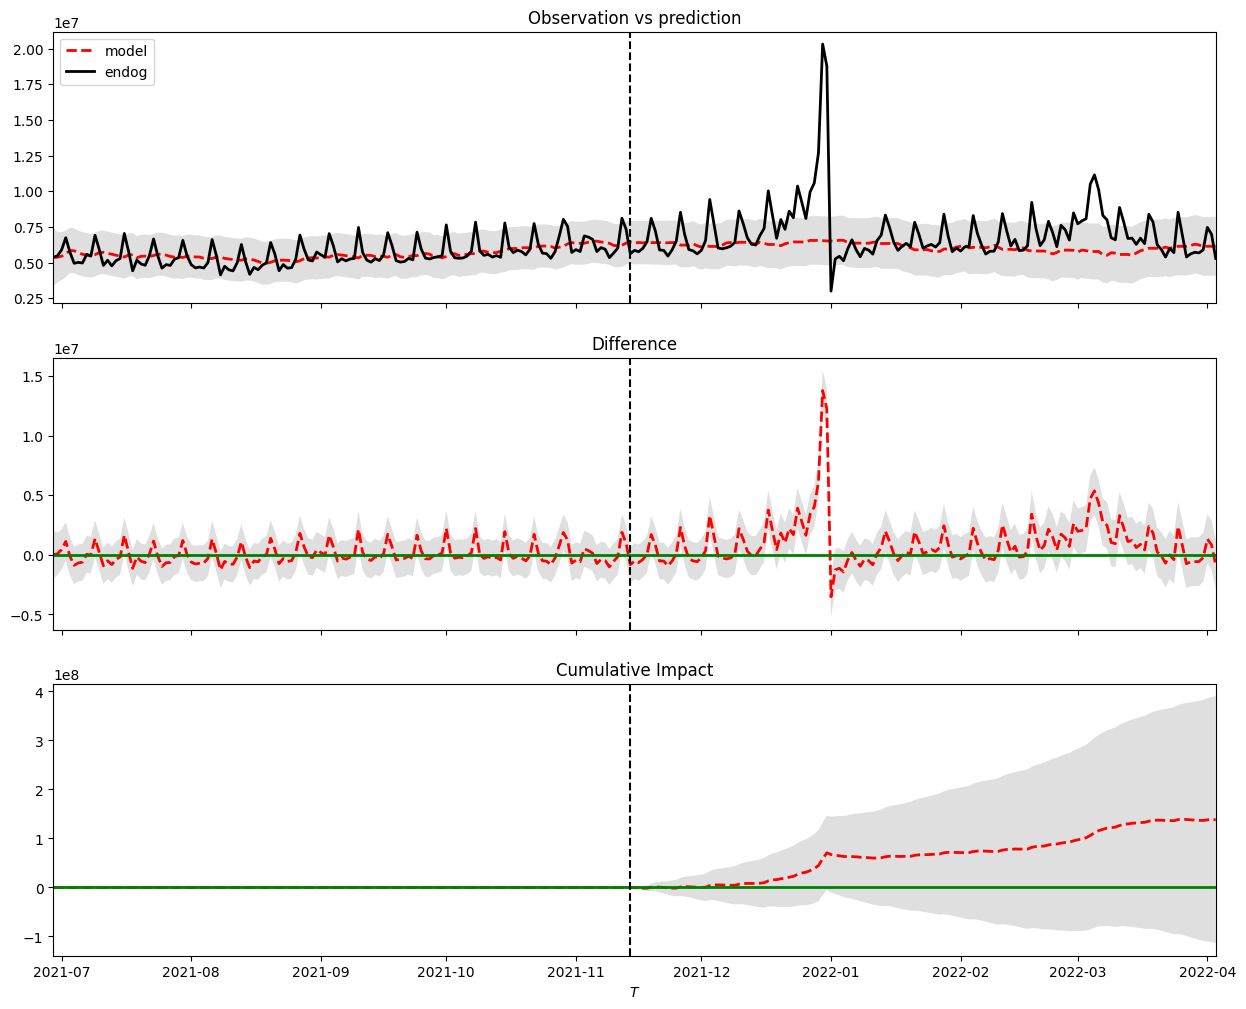

In [19]:
ts_impact.plot()

### Add "supermarket" searches worldwide| Why? Because it is an external variable known related to the outcome variable but unrelated to the treatment. In order to combat the Christmas peak. Moreover, searches are per week thus have to set the daily searches to the week average ourselves

In [37]:
g_trends = pd.read_csv('../data/multiTimeline(3).csv')
g_trends = g_trends.iloc[1:]
g_trends.rename(columns={'Categorie: Alle categorieën': 'searches'}, inplace=True)
g_trends.index = pd.to_datetime(g_trends.index)
g_trends['searches'] = g_trends['searches'].astype(int)
g_trends.sort_index()

,searches
2021-07-04,67
2021-07-11,68
2021-07-18,77
2021-07-25,70
2021-08-01,66
2021-08-08,59
2021-08-15,71
2021-08-22,66
2021-08-29,66
2021-09-05,55


In [38]:
searches_full = pd.merge(all_days_df, g_trends , how='outer', left_index=True, right_index=True)
searches_full['searches'].fillna(method='ffill', limit=6, inplace=True)
searches_full['searches'].iloc[:7] = 45.0

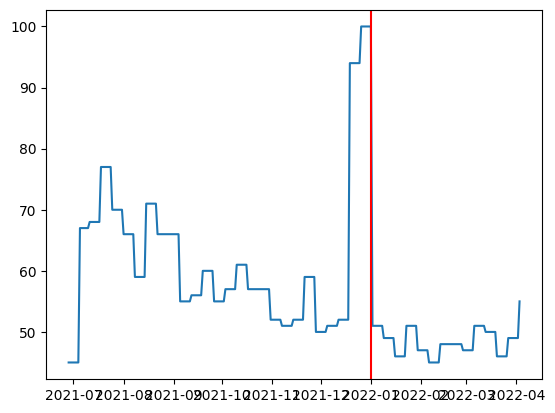

In [39]:
# create line chart of AH searches
plt.plot(searches_full.index,  searches_full['searches'])
plt.axvline(x=pd.to_datetime('2022-01-01'), color='red')
plt.show()

In [40]:
ts_data2 = pd.merge(ts_data, searches_full, how='outer', left_on='date', right_index=True)

In [41]:
ts_data2

,revenue,close,searches
date,,,
2021-06-28,5358695.20,4290.61,45.0
2021-06-29,5377477.76,4291.80,45.0
2021-06-30,5464551.08,4297.50,45.0
2021-07-01,5891338.36,4319.94,45.0
2021-07-02,6743656.05,4352.34,45.0
...,...,...,...
2022-03-30,5679899.28,4602.45,49.0
2022-03-31,5888872.90,4530.41,49.0
2022-04-01,7470889.75,4545.86,49.0


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.43060D+00    |proj g|=  2.10889D-01

At iterate    5    f=  1.33355D+00    |proj g|=  4.69958D-02

At iterate   10    f=  1.33169D+00    |proj g|=  7.59456D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     17      1     0     0   8.955D-06   1.332D+00
  F =   1.3316904447251126     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


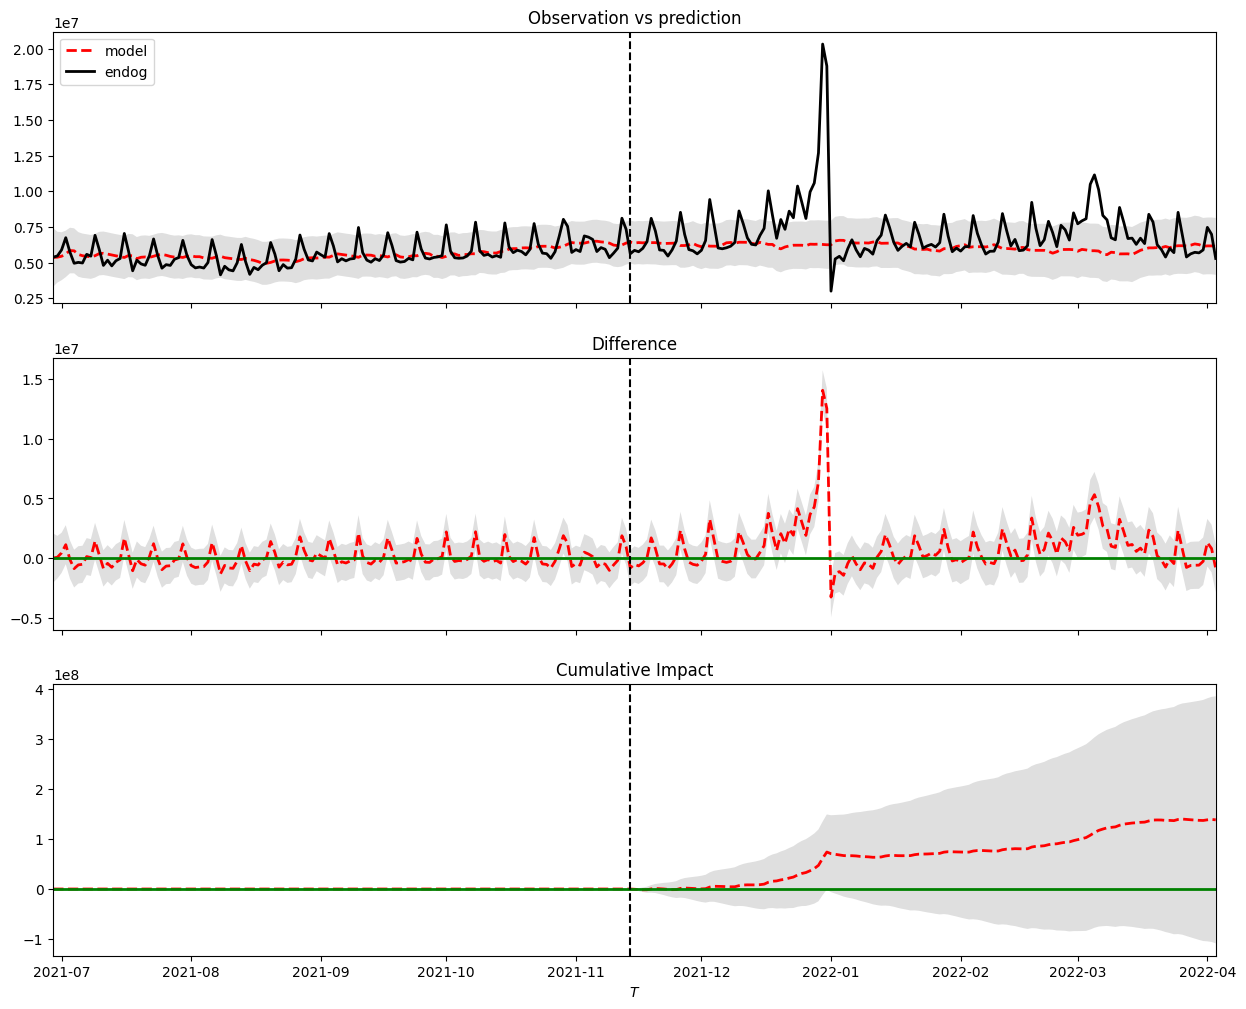

In [42]:
ts_impact = CausalImpact(ts_data2, ts_pre_period, ts_post_period)
ts_impact.run()
ts_impact.plot()

In [43]:
ts_impact.summary()

                                   Average               Cumulative
Actual                             7112852                995799350
Predicted                          6125561                857578660
95% CI                  [4362155, 7888967]  [610701820, 1104455500]
                                                                   
Absolute Effect                     987290                138220689
95% CI                  [2750696, -776115]  [385097530, -108656150]
                                                                   
Relative Effect                      16.1%                    16.1%
95% CI                     [44.9%, -12.7%]          [44.9%, -12.7%]
                                                                   
P-value                               0.0%                         
Prob. of Causal Effect              100.0%                         


### Revenue of the loyal customers customers in period 1 and 2 who made use of the LP to compare with the year after. Have to shift the datetime column 1 day backward due to previous year

In [129]:
loyal_customers = pd.read_csv("../data/loyal_customer_data.csv", index_col=0)
loyal_customers['date_code'] = pd.to_datetime(loyal_customers['date_code'])

In [210]:
min(loyal_customers['date_code'])

Timestamp('2020-06-29 00:00:00')

In [130]:
loyal_12 = loyal_customers[(loyal_customers['period_code'] == 1) | (loyal_customers['period_code'] ==2)]

In [131]:
loyal_12 = loyal_12[loyal_12['redeemer_latest_ind'] == 1]

In [209]:
loyal_12.sort_values(by='date_code')

,store_code,date_code,period_code,redeemer_latest_ind,customer_code,customer_segment_level_1_code,customer_segment_level_2_code,revenue_after_discount_incl_vat,quantity_sold,store_type_new
930809,329,2021-06-28,1,1,1344430,1.0,1.0,801.0,5.000,Daily
2590845,419,2021-06-28,1,1,1234570,3.0,6.0,766.0,3.000,Daily
2527465,278,2021-06-28,1,1,1197460,3.0,6.0,4821.0,32.922,Hypermarket
1844623,274,2021-06-28,1,1,1331900,3.0,6.0,1315.0,7.000,Hypermarket
2878253,372,2021-06-28,1,1,1118170,3.0,6.0,37.0,1.000,Daily
...,...,...,...,...,...,...,...,...,...,...
1836179,283,2022-04-03,2,1,1028250,1.0,1.0,8956.0,25.722,Hypermarket
2997698,270,2022-04-03,2,1,1026710,1.0,1.0,5788.0,28.042,Hypermarket
2210000,364,2022-04-03,2,1,1247340,3.0,6.0,3521.0,12.000,Hypermarket
2796484,385,2022-04-03,2,1,1144900,1.0,1.0,2512.0,13.360,Other


In [133]:
loyal_12['date_code'] = loyal_12['date_code'] + pd.offsets.DateOffset(years=1)

In [137]:
loyal_12['date_code'] = loyal_12['date_code'] - timedelta(days=1)

In [138]:
revenue_loyal_12_with = loyal_12.groupby('date_code')['revenue_after_discount_incl_vat'].sum().reset_index()

In [139]:
revenue_loyal_12_with.set_index('date_code', inplace=True)

In [140]:
revenue_loyal_12_with

,revenue_after_discount_incl_vat
date_code,
2021-06-28,4908626.15
2021-06-29,5178638.79
2021-06-30,5801979.21
2021-07-01,5348832.87
2021-07-02,6309848.30
...,...
2022-03-30,5833013.57
2022-03-31,5424634.67
2022-04-01,7336093.74


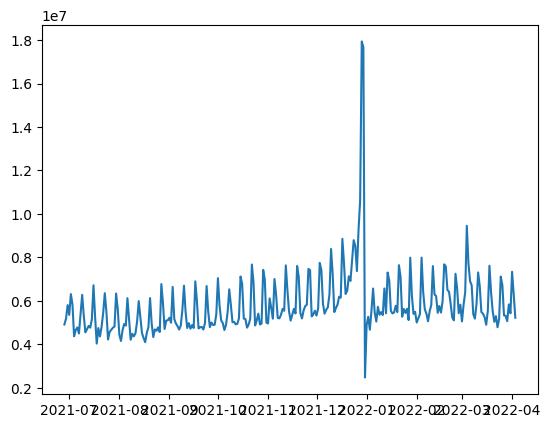

In [141]:
# create line chart
plt.plot(revenue_loyal_12_with.index,  revenue_loyal_12_with['revenue_after_discount_incl_vat'])
plt.show()

In [142]:
revenue_loyal_12_with.to_csv('../data/revenue_lc_12_with.csv')

### Revenue of all the customers in period 12 /edit: Maybe not the best due to wrong comparison of the type of customers. Therefore, use loyal_customers defined in the segmentation that have made use of the LP in period 12

In [81]:
ts_data2

,revenue,close,searches
date,,,
2021-06-28,5358695.20,4290.61,45.0
2021-06-29,5377477.76,4291.80,45.0
2021-06-30,5464551.08,4297.50,45.0
2021-07-01,5891338.36,4319.94,45.0
2021-07-02,6743656.05,4352.34,45.0
...,...,...,...
2022-03-30,5679899.28,4602.45,49.0
2022-03-31,5888872.90,4530.41,49.0
2022-04-01,7470889.75,4545.86,49.0


In [143]:
ts_data3 = pd.merge(ts_data2, revenue_loyal_12_with, how='outer', left_index=True, right_index=True)

In [145]:
ts_data3

,revenue,close,searches,revenue_after_discount_incl_vat
date,,,,
2021-06-28,5358695.20,4290.61,45.0,4908626.15
2021-06-29,5377477.76,4291.80,45.0,5178638.79
2021-06-30,5464551.08,4297.50,45.0,5801979.21
2021-07-01,5891338.36,4319.94,45.0,5348832.87
2021-07-02,6743656.05,4352.34,45.0,6309848.30
...,...,...,...,...
2022-03-30,5679899.28,4602.45,49.0,5833013.57
2022-03-31,5888872.90,4530.41,49.0,5424634.67
2022-04-01,7470889.75,4545.86,49.0,7336093.74


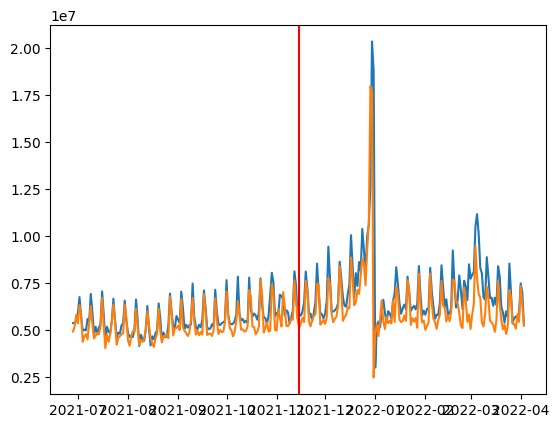

In [206]:
# create line chart
plt.plot(ts_data3.index, ts_data3['revenue'])
plt.plot(ts_data3.index, ts_data3['revenue_after_discount_incl_vat'])
plt.axvline(x=pd.to_datetime('2021-11-15'), color='red')
plt.show()

In [214]:
outliers = ts_data3[ts_data3['revenue'] > 9000000]

In [215]:
outliers

,revenue,close,searches,revenue_after_discount_incl_vat
date,,,,
2021-12-03,9424111.66,4538.43,50.0,7743028.54
2021-12-17,10031281.81,4620.64,52.0,8852715.50
2021-12-24,10365637.85,4725.79,94.0,8791500.35
2021-12-25,9250090.57,4725.79,94.0,8518957.57
2021-12-27,9956788.05,4791.19,100.0,9262887.75
2021-12-28,10579344.85,4786.35,100.0,10626561.16
2021-12-29,12689384.54,4793.06,100.0,17934195.77
2021-12-30,20325564.55,4778.73,100.0,17669060.16
2021-12-31,18786829.13,4766.18,100.0,2471111.44


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.99850D-01    |proj g|=  5.89604D-01

At iterate    5    f=  6.16381D-01    |proj g|=  9.53054D-02

At iterate   10    f=  6.14094D-01    |proj g|=  4.60499D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     25      1     0     0   4.587D-05   6.141D-01
  F =  0.61409263442499051     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


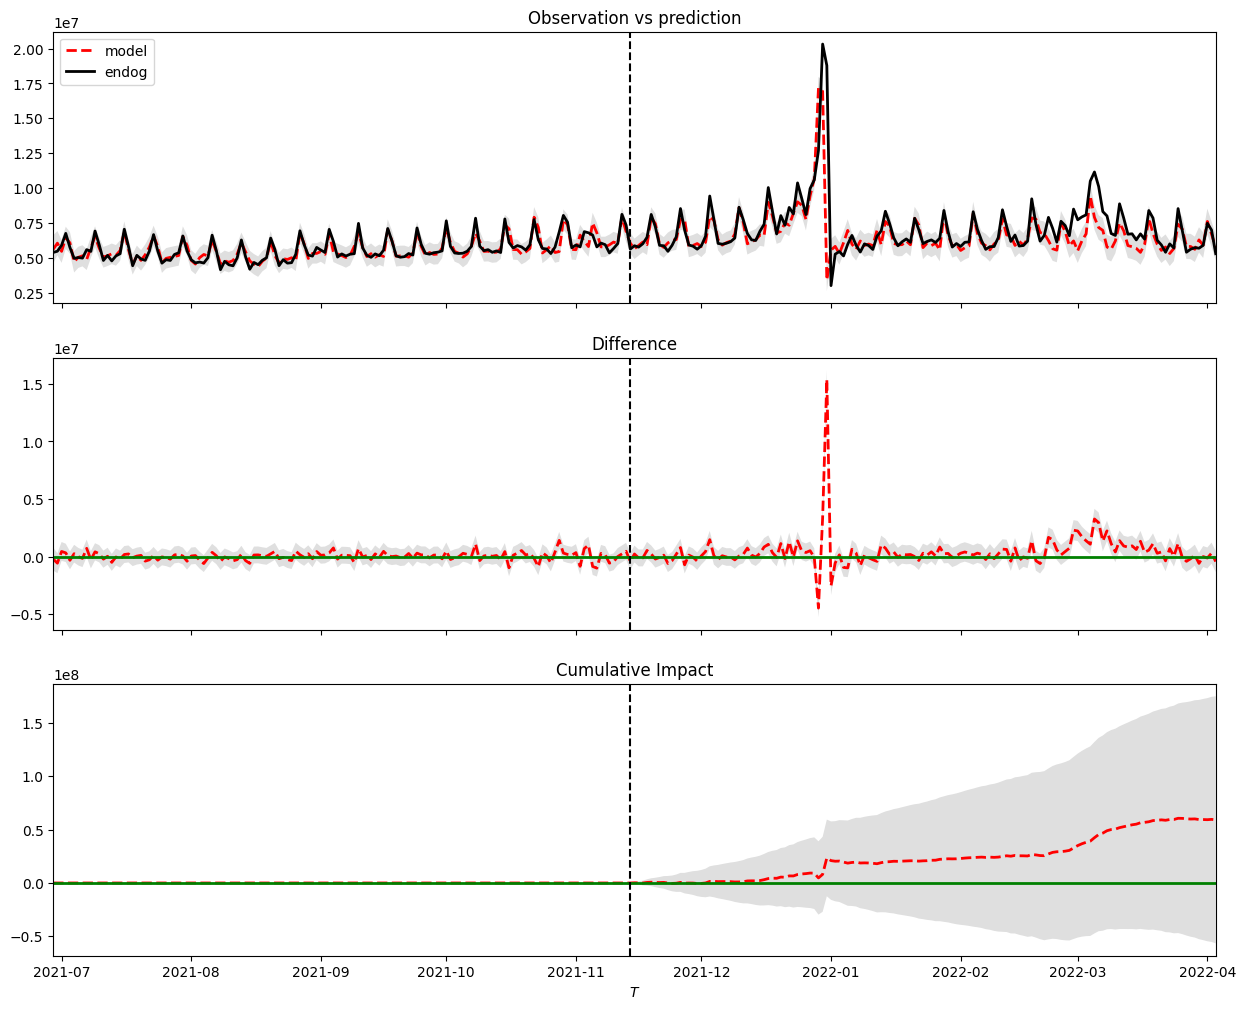

In [146]:
ts_impact = CausalImpact(ts_data3, ts_pre_period, ts_post_period)
ts_impact.run()
ts_impact.plot()

In [147]:
ts_impact.summary()

                                   Average               Cumulative
Actual                             7112852                995799350
Predicted                          6690028                936603966
95% CI                  [5862640, 7517415]  [820769735, 1052438198]
                                                                   
Absolute Effect                     422824                 59195383
95% CI                  [1250211, -404563]   [175029615, -56638847]
                                                                   
Relative Effect                       6.3%                     6.3%
95% CI                      [18.7%, -6.0%]           [18.7%, -6.0%]
                                                                   
P-value                               0.0%                         
Prob. of Causal Effect              100.0%                         


In [211]:
ts_impact.summary(output="report")

During the post-intervention period, the response             variable had an average value of             approx.
7112852.  By contrast, in  the absence of an intervention, we would have expected an average response of 6690028. The
95% interval of this counterfactual prediction is [5862640, 7517415]. Subtracting this prediction from the observed
response yields an estimate of the causal effect the intervention had on the response variable. This effect is 422824
with a 95% interval of [1250211, -404563]. For a discussion of the significance of this effect, see below.


 Summing up the individual data points during the post-intervention period (which can only sometimes be meaningfully
interpreted), the response variable had an overall value of 995799350.  By contrast, had  the intervention not taken
place, we would have expected a sum of 936603966. The 95% interval of this prediction is [820769735, 1052438198]


 The above results are given in terms of absolute numbers. In relative term

In [153]:
ts_post_period

['2021-11-15', '2022-04-03']

In [166]:
params = pd.DataFrame(ts_impact.results.results.params).T
params.columns = ts_impact.results.results.param_names 
betas = [column for column in params.columns if column.startswith("beta")]
beta_params = params.loc[:, betas]

In [167]:
beta_params

,beta.x1,beta.x2,beta.x3
0,0.031559,0.013086,0.838447


In [171]:
exog_post = ts_data3.loc['2021-11-15':, 'close':]
exog_post

,close,searches,revenue_after_discount_incl_vat
date,,,
2021-11-15,4682.80,52.0,5088853.22
2021-11-16,4700.90,52.0,5356558.06
2021-11-17,4688.67,52.0,5629897.98
2021-11-18,4704.54,52.0,5415987.64
2021-11-19,4697.96,52.0,7603014.96
...,...,...,...
2022-03-30,4602.45,49.0,5833013.57
2022-03-31,4530.41,49.0,5424634.67
2022-04-01,4545.86,49.0,7336093.74


In [189]:
# TODO: something like this
params = pd.DataFrame(ts_impact.results.results.params).T
params.columns = ts_impact.results.results.param_names 
betas = [column for column in params.columns if column.startswith("beta")]
beta_params = params.loc[:, betas]
# exogenous data for the post period
exog_post = ts_data3.loc['2021-11-15':, 'close':]

In [190]:
type(beta_params)

pandas.core.frame.DataFrame

<Axes: >

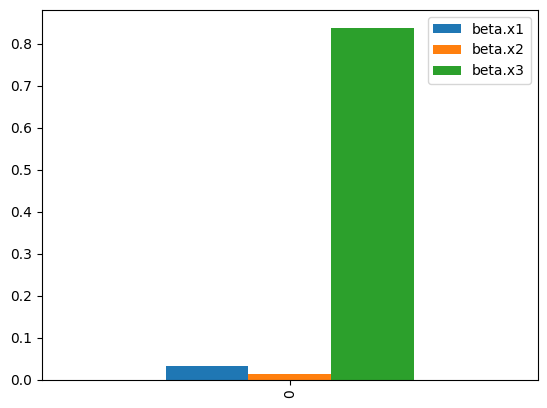

In [191]:
beta_params.plot.bar()